# Training Models

In [1]:
#Importing Libraries
import sys
import os
import numpy as np
import pandas as pd
import mlflow

In [2]:
#importing local scripts
#Adding scripts path
sys.path.append(os.path.abspath(os.path.join('..')))
#importing data_manipulator script
from scripts.ML_modelling_utils import *

## Importing and Fixing Data

In [3]:
#Importing the collected Data
path = 'data/AdSmartABdata.csv'
repo = 'https://github.com/DePacifier/abtest-mlops'
all_dfs = import_all_data_using_tagslist(path=path, repo=repo, tags=[
                                         'chrome-mobile', 'chrome-mobile-view', 'facebook', 'samsung-internet', 'platform-6'])


In [4]:
all_dfs['chrome-mobile'].head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,response
0,378645d2-f8cf-43c0-b1be-e699d846e596,control,2020-07-04,6,Generic Smartphone,6,Chrome Mobile,0
1,ef334830-f200-4c1b-aea2-b01b96ca0950,exposed,2020-07-03,12,Generic Smartphone,6,Chrome Mobile,0
2,49e7690d-4825-499c-9553-756af3198a10,control,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,1
3,80b9fecc-ef23-4896-bd43-b81c074f49c3,control,2020-07-09,17,Generic Smartphone,6,Chrome Mobile,1
4,3dd09b49-9b11-45bd-ab0d-e279a8e5edc7,exposed,2020-07-03,0,Generic Smartphone,6,Chrome Mobile,0


In [5]:
# Spliting the date column to year, month and day columns and removing it
all_dfs_date_fixed = split_date_to_numbers(all_dfs, 'date')
all_dfs_date_fixed['chrome-mobile'].head(5)

,auction_id,experiment,hour,device_make,platform_os,browser,response,year,month,day
0,378645d2-f8cf-43c0-b1be-e699d846e596,control,6,Generic Smartphone,6,Chrome Mobile,0,2020,7,4
1,ef334830-f200-4c1b-aea2-b01b96ca0950,exposed,12,Generic Smartphone,6,Chrome Mobile,0,2020,7,3
2,49e7690d-4825-499c-9553-756af3198a10,control,10,Generic Smartphone,6,Chrome Mobile,1,2020,7,7
3,80b9fecc-ef23-4896-bd43-b81c074f49c3,control,17,Generic Smartphone,6,Chrome Mobile,1,2020,7,9
4,3dd09b49-9b11-45bd-ab0d-e279a8e5edc7,exposed,0,Generic Smartphone,6,Chrome Mobile,0,2020,7,3


In [6]:
#drop columns from each data, the grouping column b/c its a univalue column
#We have 5 dataframes of which 4 are grouped based on browser and 1 based on platform
for i in all_dfs_date_fixed:
    if(i != "platform-6"):
        all_dfs_date_fixed[i].drop('browser', axis=1, inplace=True)
    else:
        all_dfs_date_fixed[i].drop('platform_os', axis=1, inplace=True)

In [7]:

data_type_fixed_dfs = change_columns_to_numbers(all_dfs_date_fixed, ['experiment', 'device_make', 'browser'])
data_type_fixed_dfs['platform-6'].sample(5)


,auction_id,experiment,hour,device_make,browser,response,year,month,day
847,ea52fbf9-292e-4a6a-a80a-9c0529abf866,0,14,101,3,0,2020,7,10
609,af93dc3a-75b2-4b54-b3e6-c6afb098696a,1,6,13,2,1,2020,7,7
789,e144ec56-a30e-4661-a7c7-349554c61942,0,15,13,1,1,2020,7,3
673,424785d3-ba8a-4662-99ec-d645cf6a9f94,1,6,68,5,1,2020,7,9
828,62302756-551a-4f09-b0d6-d0c097885fcc,0,15,64,5,1,2020,7,3


In [8]:
# #Get all train, validate and test sets
chrome_mobile_dict = get_train_validate_test_sets(data_type_fixed_dfs['chrome-mobile'], predicted_column='response', remove_columns=['auction_id'])
chrome_mobile_view_dict = get_train_validate_test_sets(data_type_fixed_dfs['chrome-mobile-view'], predicted_column='response', remove_columns=['auction_id'])
facebook_dict = get_train_validate_test_sets(data_type_fixed_dfs['facebook'], predicted_column='response', remove_columns=['auction_id'])
samsung_internet_dict = get_train_validate_test_sets(data_type_fixed_dfs['samsung-internet'], predicted_column='response', remove_columns=['auction_id'])
platform_6_dict = get_train_validate_test_sets(data_type_fixed_dfs['platform-6'], predicted_column='response', remove_columns=['auction_id'])

In [9]:
chrome_mobile_dict['train_x'].head()


,experiment,hour,device_make,platform_os,year,month,day
383,0,15,1,6,2020,7,3
338,1,5,1,6,2020,7,10
8,1,14,1,6,2020,7,9
170,1,17,1,6,2020,7,9
334,1,8,1,6,2020,7,3


# Training

> Training only done for 4 or the 5 data(samsung-internet is omitted)

In [10]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression


In [11]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


def calculate_metrics(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r_sq = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)

    return {'RMSE Score': rmse, 'R2_Squared': r_sq, 'MAE Score': mae}


In [12]:
def evaluate_model(dt_classifier,x_train, y_train ,x_test, y_test):
    print("Train Accuracy :", accuracy_score(
        y_train, dt_classifier.predict(x_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(
        y_test, dt_classifier.predict(x_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(x_test)))


In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


def plot_preds(y_test, y_preds, model_name):
    N = len(y_test)
    original = plt.scatter(np.arange(1, N+1), y_test, c='blue')
    prediction = plt.scatter(np.arange(1, N+1), y_preds, c='red')
    plt.xticks(np.arange(1, N+1))
    plt.xlabel('# Oberservation')
    plt.ylabel('Response')
    title = 'True labels vs. Predicted Labels ({})'.format(model_name)
    plt.title(title)
    # plt.figure(figsize=(20, 8))
    plt.legend((original, prediction), ('Original', 'Prediction'))
    plt.show()


In [72]:
def get_dt_graph(dt_classifier, x, show=False):
    plt.figure(figsize=(25, 20))
    tree.plot_tree(dt_classifier,
                       feature_names=x.columns,
                       class_names=['No Response', "Yes Response"],
                       filled=True)
    if(show):
        plt.show()
    return plt


## Logistic Regression Model

In [64]:
def train_logistic_model(x_train,y_train,x_valid, y_valid,cross_val_size:int=5):
    cv_acc_results = []
    model_list = []
    c = [0.001,0.01,0.1,1,10,100,1000]
    for i in c:
        with mlflow.start_run():
            model = LogisticRegression(penalty='l2', C=i, random_state=0)
            model.fit(x_train, y_train)
            kfold = KFold(n_splits=cross_val_size)
            results = cross_val_score(model, x_train, y_train, cv=kfold)
            mlflow.log_param("Model","Logistic Regression")
            mlflow.log_param("Penalty", 'l2')
            mlflow.log_metric("C Value", i)
            pre_acc_score = model.score(x_valid, y_valid)
            cv_scores = (results.mean(), results.std())
            cv_acc_results.append(cv_scores[0])
            model_list.append(model)
            measure_metrics = calculate_metrics(y_valid, y_preds=model.predict(x_valid.values))
            mlflow.log_param("Model Type", "Logistic Regression")
            mlflow.set_tag('Model Type', 'Logistic Regression')
            mlflow.log_metric("Predicted Accuracy Score",pre_acc_score)
            mlflow.log_metric("Cross Validation Mean Accuracy Score",cv_scores[0])
            mlflow.log_metric("Cross Validation Std Score",cv_scores[1])
            mlflow.log_metric("RMSE Score", measure_metrics['RMSE Score'])
            mlflow.log_metric("R2_Squared Score", measure_metrics['R2_Squared'])
            mlflow.log_metric("MAE Score", measure_metrics['MAE Score'])
            modelpath = '../models/model-%s-%f-%f-%f'%('lr',cv_scores[0],cv_scores[1],i)
            figpath = '../models/fig-%s-%f-%f-%f.png'%('lr', cv_scores[0], cv_scores[1],i)
            roc_plot = plot_roc_curve_log(x_valid, y_valid, model=model)
            try:
                roc_plot.savefig(figpath)
                mlflow.log_artifact(figpath)
                mlflow.sklearn.save_model("model",modelpath)
                mlflow.log_artifact(modelpath)
            except:
                # Model already exists
                pass
            # print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    # predicted = model.predict(x_valid.values)
    # print("Parameter Values: ")
    # print(model.coef_)
    # print(metrics.accuracy_score(y_valid, predicted))
    # print(metrics.classification_report(y_valid, predicted))
    # print(calculate_metrics(y_valid, predicted))
    # plot_preds(y_valid, predicted, "Logistic Regression")
    best_model = model_list[cv_acc_results.index(min(cv_acc_results))]


    return best_model


In [58]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def plot_roc_curve_log(x_test,y_test,model, show=False):
    logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    if(show):
        plt.show()
    
    return plt


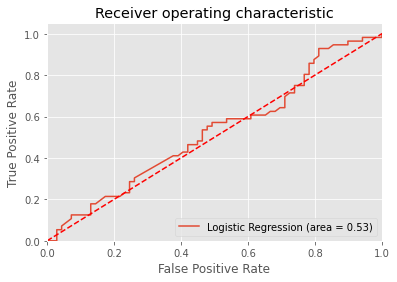

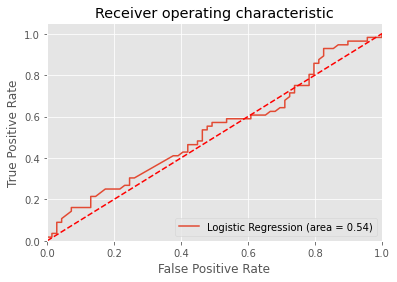

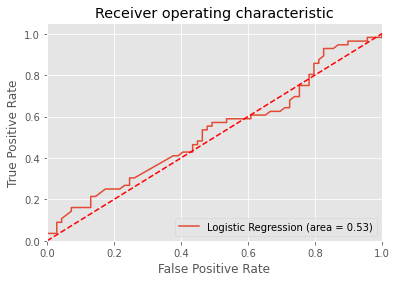

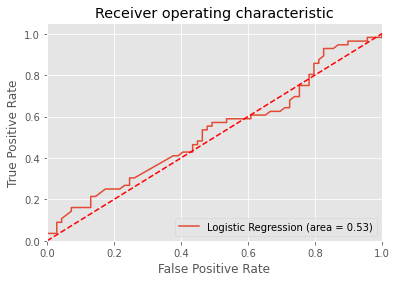

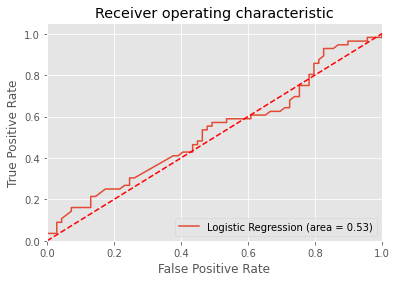

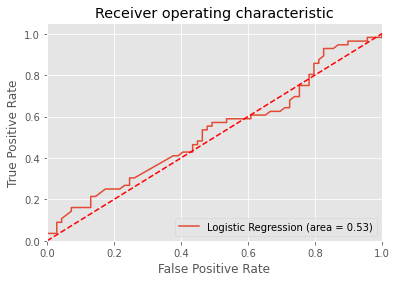

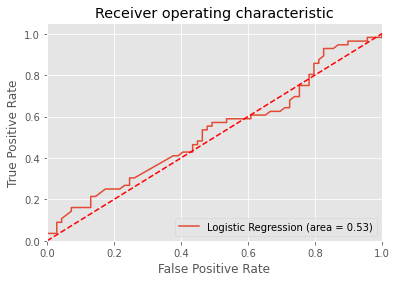

In [65]:
# For chrome mobile

chrome_mobile_model = train_logistic_model(
    chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], chrome_mobile_dict['val_x'], chrome_mobile_dict['val_y'])


In [26]:
chrome_mobile_model

LogisticRegression(C=0.01, random_state=0)

## Decision Trees

In [73]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

def train_decision_tree(x_train, y_train, x_valid, y_valid):
    mlflow.sklearn.autolog()
    dt = DecisionTreeClassifier(random_state=42)
    params = {
        'max_depth': [*range(3,15)],
        'min_samples_split': [*range(2,10)],
        'min_samples_leaf': [*range(1,10)],
        'criterion': ["gini", "entropy"],
        'max_features': ['sqrt','log2'],
        # 'presort': [False, True],
        'class_weight': [None, 'balanced']
    }
    grid_search = GridSearchCV(estimator=dt,
                            param_grid=params,
                            cv=5, n_jobs=-1, verbose=1, scoring="accuracy")
    grid_search.fit(x_train, y_train)

    with mlflow.start_run():
        measure_metrics = calculate_metrics(y_valid, y_preds=grid_search.best_estimator_.predict(x_valid.values))
        mlflow.log_param("Model Type", "Decision Tree")
        mlflow.set_tag('Model Type', 'Decision Tree')
        mlflow.set_tag('Model Status', 'Best')
        mlflow.log_metric("Predicted Accuracy Score", grid_search.score(x_valid,y_valid))
        mlflow.log_metric("RMSE Score", measure_metrics['RMSE Score'])
        mlflow.log_metric("R2_Squared Score",measure_metrics['R2_Squared'])
        mlflow.log_metric("MAE Score", measure_metrics['MAE Score'])

        modelpath = '../models/model-%s-%f-%f' % ('dt', grid_search.best_score_, grid_search.best_index_)
        figpath = '../models/fig-%s-%f-%f.png' % ('dt', grid_search.best_score_, grid_search.best_index_)
        dt_graph = get_dt_graph(grid_search.best_estimator_, x_train)
        try:
            dt_graph.savefig(figpath)
            mlflow.log_artifact(figpath)
            mlflow.sklearn.save_model("model", modelpath)
            mlflow.log_artifact(modelpath)
        except:
            # Model already exists
            pass
    # score_df = pd.DataFrame(grid_search.cv_results_)
    # score_df.nlargest(5,"mean_test_score")
    # dt_best = grid_search.best_estimator_
    # print("Score: {}".format(clf.score(x_valid, y_valid)))
    # print(metrics.accuracy_score(y_valid, predicted))
    # print(metrics.classification_report(y_valid, predicted))
    # print(clf.best_score_, clf.best_params_)
    # print(calculate_metrics(y_valid, predicted))
    # plot_preds(y_valid, predicted, "Decision Tree")

    return grid_search


In [74]:
chrome_mobile_tree_model = train_decision_tree(
    chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], chrome_mobile_dict['val_x'], chrome_mobile_dict['val_y'])

2021/07/24 16:39:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fc8135318c4348c8b6a9300948992dbe', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2021/07/24 16:39:24 WARNING mlflow.utils: Truncated the value of the key `param_grid`. Truncated value: `{'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2'], 'class_weight': [None, 'ba...`


Fitting 5 folds for each of 6912 candidates, totalling 34560 fits


2021/07/24 16:39:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Python38\lib\site-packages\mlflow\models\signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2021/07/24 16:39:54 INFO mlflow.sklearn.utils: Logging the 5 best runs, 6907 runs will be omitted.


TypeError: run() missing 1 required positional argument: 'uri'

In [52]:
chrome_mobile_tree_model.nlargest(5, "mean_test_score")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1888,0.005402,0.000800,0.003998,0.002094,None,entropy,4,sqrt,3,2,"{'class_weight': None, 'criterion': 'entropy',...",0.62,0.54,0.58,0.59,0.57,0.58,0.026077,1
1889,0.005206,0.000399,0.002993,0.000012,None,entropy,4,sqrt,3,3,"{'class_weight': None, 'criterion': 'entropy',...",0.62,0.54,0.58,0.59,0.57,0.58,0.026077,1
1890,0.004941,0.000148,0.003194,0.000411,None,entropy,4,sqrt,3,4,"{'class_weight': None, 'criterion': 'entropy',...",0.62,0.54,0.58,0.59,0.57,0.58,0.026077,1
1891,0.005000,0.000631,0.003207,0.000397,None,entropy,4,sqrt,3,5,"{'class_weight': None, 'criterion': 'entropy',...",0.62,0.54,0.58,0.59,0.57,0.58,0.026077,1
1892,0.005600,0.000489,0.003399,0.000491,None,entropy,4,sqrt,3,6,"{'class_weight': None, 'criterion': 'entropy',...",0.62,0.54,0.58,0.59,0.57,0.58,0.026077,1


## XGB Boost

In [19]:

# k-fold cross validation evaluation of xgboost model
from scipy.stats import uniform
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
# CV model
def train_xgb_classifier(x_train, y_train, x_valid, y_valid):
    
    clf_xgb = XGBClassifier(objective='binary:logistic')
    params = {
        'max_depth': [*range(3,10)],
        'min_child_weight':[*range(1,5)],
        'learning_rate':uniform(0.01, 0.59),
        'subsample':uniform(0.3,0.6),
        'colsample_bytree':uniform(0.5,0.4),
    }

    kfold = KFold(n_splits=5,shuffle=True)

    random_search = RandomizedSearchCV(clf_xgb, param_distributions=params,
    cv=kfold, n_iter=5, scoring='accuracy', error_score=0, verbose=1, n_jobs=-1)

    random_search.fit(x_train, y_train)

    score_df = pd.DataFrame(random_search.cv_results_)
    score_df.nlargest(5, "mean_test_score")
    xgb_best_classifier = random_search.best_estimator_
    #additional
    # random_search.best_params_
    # random_search.get_params
    # random_search.best_index_
    # random_search.best_score_


    # model = XGBClassifier()
    # model.fit(x_train, y_train)
    # make predictions for test data
    # predicted = model.predict(x_valid)
    # evaluate predictions
    # print(metrics.accuracy_score(y_valid, predicted))
    # print(metrics.classification_report(y_valid, predicted))
    # print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # kfold = KFold(n_splits=5)
    # results = cross_val_score(model, x_train, y_train, cv=kfold)
    # print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    # print(calculate_metrics(y_valid, predicted))
    # plot_preds(y_valid, predicted, "XGB Boost")

    return score_df


In [76]:
chrome_mobile_tree_model = train_xgb_classifier(
    chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], chrome_mobile_dict['val_x'], chrome_mobile_dict['val_y'])


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[10:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [79]:
pd.set_option('max_column', None)
chrome_mobile_tree_model.nlargest(5, "mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.671635,0.021358,0.008481,0.002608,0.787815,0.469783,5,2,0.346806,"{'colsample_bytree': 0.7878151400317767, 'lear...",0.61,0.47,0.56,0.50,0.48,0.524,0.053141,1
2,0.935957,0.085548,0.007574,0.002234,0.811896,0.090973,8,1,0.319769,"{'colsample_bytree': 0.8118963936274005, 'lear...",0.59,0.53,0.52,0.56,0.42,0.524,0.057480,1
4,0.486974,0.098152,0.006838,0.001583,0.782624,0.261928,8,3,0.337967,"{'colsample_bytree': 0.7826240610510249, 'lear...",0.57,0.54,0.51,0.52,0.43,0.514,0.046733,3
0,0.800279,0.012412,0.017919,0.004120,0.728796,0.367991,5,1,0.437678,"{'colsample_bytree': 0.7287961597451144, 'lear...",0.56,0.55,0.49,0.52,0.44,0.512,0.043543,4
3,0.532395,0.027894,0.006174,0.002096,0.732787,0.56934,3,4,0.761657,"{'colsample_bytree': 0.7327868636403403, 'lear...",0.53,0.56,0.48,0.47,0.42,0.492,0.048744,5
